In [ ]:
import pydicom
import numpy as np
import os
from scipy.ndimage import zoom
import tensorflow as tf
import keras
from keras import layers
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def load_dicom_series(dicom_dir, target_size=(64, 224, 224)):
    dicom_files = []
    for filename in os.listdir(dicom_dir):
        if filename.endswith(".dcm"):
            path = os.path.join(dicom_dir, filename)
            try:
                dicom = pydicom.dcmread(path, force=True)
                dicom_files.append(dicom)
            except Exception as e:
                print(f"Error reading {path}: {e}")
    
    if not dicom_files:
        raise ValueError(f"No DICOMs found in {dicom_dir}")

    try:
        dicom_files.sort(key=lambda x: int(x.InstanceNumber))
    except:
        try:
            dicom_files.sort(key=lambda x: float(x.ImagePositionPatient[2]))
        except:
            dicom_files.sort(key=lambda x: x.filename)

    slices = []
    for dcm in dicom_files:
        img = dcm.pixel_array.astype(np.float32)
        if hasattr(dcm, "RescaleSlope") and hasattr(dcm, "RescaleIntercept"):
            img = img * dcm.RescaleSlope + dcm.RescaleIntercept
        slices.append(img)
    
    volume = np.stack(slices, axis=0)
    
    # Normalize Hounsfield Units (window [-1000, 400])
    volume = np.clip(volume, -1000, 400)
    volume = (volume + 1000) / 1400.0
    
    # Resize to target shape (depth, height, width)
    zoom_factors = (
        target_size[0] / volume.shape[0],
        target_size[1] / volume.shape[1],
        target_size[2] / volume.shape[2],
    )
    volume = zoom(volume, zoom_factors, order=1)
    
    return volume.astype(np.float32)


In [ ]:
def create_keras_dataset(csv_file, batch_size=2, target_size=(64,224,224)):
    
    df = pd.read_csv(csv_file)
    
    # Map stages {2,4} → {0,1}
    df["stage"] = df["stage"].replace({2: 0, 4: 1})
    
    paths = df["ct_folder_path"].values
    labels = df["stage"].values.astype(np.int32)
    
    def load_and_preprocess(path, label):
        volume = tf.numpy_function(
            func=lambda x: load_dicom_series(x.decode("utf-8"), target_size),
            inp=[path],
            Tout=tf.float32
        )
        # Add channel dimension for Keras Conv3D
        volume = tf.expand_dims(volume, axis=-1)
        volume.set_shape([target_size[0], target_size[1], target_size[2], 1])
        label = tf.cast(label, tf.int32)
        return volume, label
    
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [ ]:
train_dataset = create_keras_dataset("datasets/colorectal_ct_patients.csv", batch_size=2)


import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("datasets/colorectal_ct_patients.csv")

# First split: train vs temp (val+test)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["stage"], random_state=42)

# Second split: validation vs test
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["stage"], random_state=42)

train_df.to_csv("datasets/colorectal_ct_train.csv", index=False)
val_df.to_csv("datasets/colorectal_ct_val.csv", index=False)
test_df.to_csv("datasets/colorectal_ct_test.csv", index=False)

train_dataset = create_keras_dataset("datasets/colorectal_ct_train.csv", batch_size=2)
val_dataset   = create_keras_dataset("datasets/colorectal_ct_val.csv", batch_size=2)
test_dataset  = create_keras_dataset("datasets/colorectal_ct_test.csv", batch_size=2)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.shuffle(10).prefetch(AUTOTUNE)
val_dataset   = val_dataset.prefetch(AUTOTUNE)
test_dataset  = test_dataset.prefetch(AUTOTUNE)

# Quick check
for vol, lbl in train_dataset.take(1):
    print(vol.shape, lbl)


Train: 298, Val: 64, Test: 65
(2, 64, 224, 224, 1) tf.Tensor([1 0], shape=(2,), dtype=int32)


Label: 0


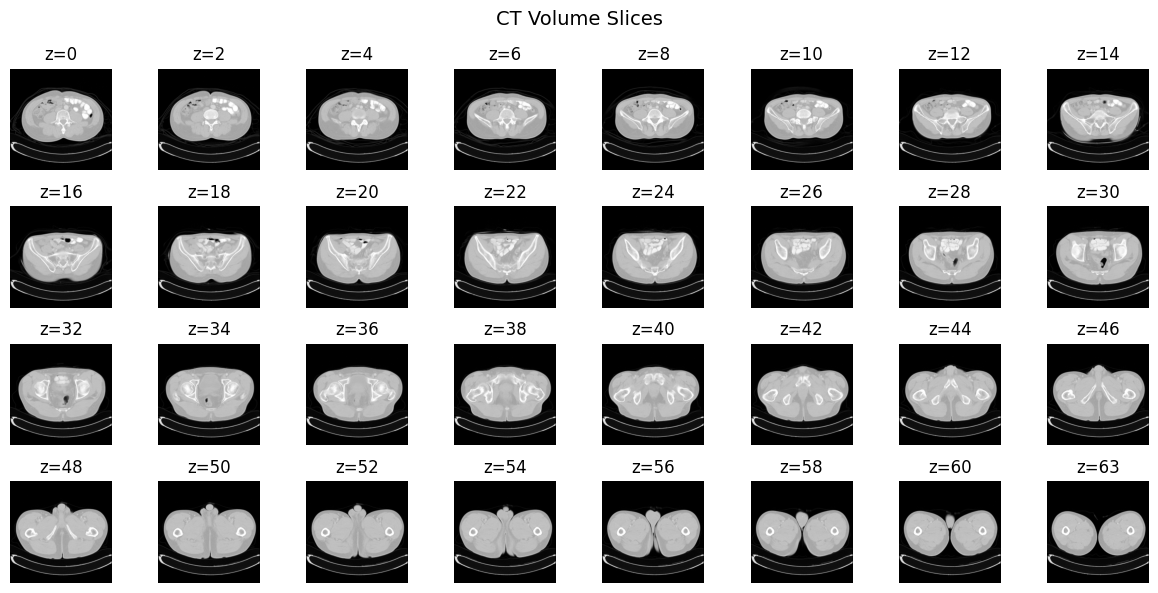

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_slices(volume, num_rows=4, num_cols=8):
    """
    Display a grid of slices from a 3D CT volume.
    volume: numpy array of shape (depth, height, width)
    """
    num_slices = num_rows * num_cols
    depth = volume.shape[0]
    
    # Pick evenly spaced slices
    indices = np.linspace(0, depth - 1, num_slices, dtype=int)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
    
    for i, ax in enumerate(axes.flat):
        if i < len(indices):
            slice_img = volume[indices[i], :, :]
            ax.imshow(slice_img, cmap='gray')
            ax.axis('off')
            ax.set_title(f"z={indices[i]}")
    plt.suptitle("CT Volume Slices", fontsize=14)
    plt.tight_layout()
    plt.show()

for vol, lbl in train_dataset.take(1):
    volume = vol[0].numpy().squeeze()  # (64, 224, 224)
    label = lbl[0].numpy()
    print("Label:", label)
    plot_slices(volume, num_rows=4, num_cols=8)


In [13]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((depth, height, width, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()


Model: "3dcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 128, 128,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 62, 126, 126,   │         1,792 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 31, 63, 63, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 63, 63, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 29, 61, 61, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 14, 30, 30, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 30, 30, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 12, 28, 28,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 6, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 14, 14, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 4, 12, 12, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 2, 6, 6, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 6, 6, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,352,897 (5.16 MB)

 Trainable params: 1,351,873 (5.16 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
model = get_model(depth=64, height=224, width=224)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.keras", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)


# Train
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,
    verbose=1
)



Model: "3dcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 224, 224,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 62, 222, 222,   │         1,792 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 31, 111, 111,   │             0 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 31, 111, 111,   │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 29, 109, 109,   │       110,656 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 14, 54, 54, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 54, 54, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 12, 52, 52,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 6, 26, 26, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 26, 26, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 4, 24, 24, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 2, 12, 12, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 2, 12, 12, 256) │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,352,897 (5.16 MB)

 Trainable params: 1,351,873 (5.16 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/50
  3/149 ━━━━━━━━━━━━━━━━━━━━ 45:48 19s/step - accuracy: 0.4167 - loss: 0.6680 